In [1]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


### Importing Libraries

In [2]:
import fastf1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
fastf1.Cache.enable_cache('/tmp')

### Data preprocessing

In [4]:
def extract_data(year, gp_name):
  race_session = fastf1.get_session(year, gp_name, 'R')
  race_session.load()

  quali_session = fastf1.get_session(year, gp_name, 'Q')
  quali_session.load()

  laps = race_session.laps.copy()
  weather = race_session.weather_data.copy()
  results = race_session.results
  qualis = quali_session.results

  laps.sort_values('LapStartTime', inplace=True)
  weather.sort_values('Time', inplace=True)

  laps = pd.merge_asof(laps, weather, left_on='LapStartTime', right_on='Time', direction='nearest')
  laps = laps[laps['IsAccurate'] & ~laps['PitInTime'].notnull() & ~laps['PitOutTime'].notnull()]

  data = []
  for driver in race_session.drivers:
    driver_info = race_session.get_driver(driver)

    driver_laps = laps[laps['DriverNumber'] == driver]
    if driver_laps.empty or driver not in results['DriverNumber'].values:
        continue

    race_result = results[results['DriverNumber'] == driver]
    quali_result = qualis[qualis['DriverNumber'] == driver]

    finish_position = race_result['Position'].values[0]
    grid_position = race_result['GridPosition'].values[0]

    lap_times = driver_laps['LapTime'].dt.total_seconds()

    data.append({
            'year': year,
            'GP': gp_name,
            'DriverNumber': int(driver),
            'LapTimeMean': lap_times.mean(),
            'LapTimeStd': lap_times.std(),
            'AirTempMean': driver_laps['AirTemp'].mean(),
            'HumidityMean': driver_laps['Humidity'].mean(),
            'TrackTempMean': driver_laps['TrackTemp'].mean(),
            'WindSpeedMean': driver_laps['WindSpeed'].mean(),
            'PressureMean': driver_laps['Pressure'].mean(),
            'Rainfall': driver_laps['Rainfall'].mean(),
            'Q1': pd.to_timedelta(quali_result['Q1'].values[0]).total_seconds() if pd.notnull(quali_result['Q1'].values[0]) else np.nan,
            'Q2': pd.to_timedelta(quali_result['Q2'].values[0]).total_seconds() if pd.notnull(quali_result['Q2'].values[0]) else np.nan,
            'Q3': pd.to_timedelta(quali_result['Q3'].values[0]).total_seconds() if pd.notnull(quali_result['Q3'].values[0]) else np.nan,
            'GridPosition': grid_position,
    })

  return pd.DataFrame(data)

In [5]:
country = 'Monaco'

In [6]:
data_2024 = extract_data(2024, country)
data_2023 = extract_data(2023, country)

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_dat

In [7]:
training_data = pd.concat([data_2024, data_2023], axis=0)

In [8]:
training_data

,year,GP,DriverNumber,LapTimeMean,LapTimeStd,AirTempMean,HumidityMean,TrackTempMean,WindSpeedMean,PressureMean,Rainfall,Q1,Q2,Q3,GridPosition
0,2024,Monaco,16,78.439039,1.698524,21.843421,61.289474,44.482895,0.952632,1018.567105,0.000000,71.584,70.825,70.270,1.0
1,2024,Monaco,81,78.524145,1.589224,21.844737,61.289474,44.480263,0.957895,1018.567105,0.000000,71.500,70.756,70.424,2.0
2,2024,Monaco,55,78.523079,1.759430,21.842105,61.276316,44.471053,0.960526,1018.569737,0.000000,71.543,71.075,70.518,3.0
3,2024,Monaco,4,78.532842,1.691592,21.842105,61.276316,44.471053,0.960526,1018.569737,0.000000,71.760,70.732,70.542,4.0
4,2024,Monaco,63,78.589645,2.107820,21.842105,61.289474,44.446053,0.932895,1018.569737,0.000000,71.492,70.929,70.543,5.0
5,2024,Monaco,1,78.383662,2.380197,21.844595,61.405405,44.477027,0.935135,1018.568919,0.000000,71.711,70.745,70.567,6.0
6,2024,Monaco,44,78.363986,2.529303,21.845946,61.418919,44.466216,0.922973,1018.570270,0.000000,71.528,71.056,70.621,7.0
7,2024,Monaco,22,79.975400,2.088223,21.845333,61.240000,44.470667,0.972000,1018.565333,0.000000,71.852,71.106,70.858,8.0
8,2024,Monaco,23,80.167120,1.736434,21.844000,61.240000,44.468000,0.970667,1018.565333,0.000000,71.623,71.216,70.948,9.0
9,2024,Monaco,10,80.246427,1.768971,21.846667,61.320000,44.454667,0.944000,1018.565333,0.000000,71.714,70.896,71.311,10.0


In [9]:
X = training_data.drop(columns=['year', 'GP', 'LapTimeMean'])
y = training_data['LapTimeMean']

In [10]:
X = pd.get_dummies(X, columns=['DriverNumber'])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
features_to_scale = ['AirTempMean', 'HumidityMean', 'TrackTempMean', 'WindSpeedMean', 'PressureMean', 'Rainfall', 'LapTimeStd', 'Q1', 'Q2', 'Q3', 'GridPosition']

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train[features_to_scale] = sc.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = sc.transform(X_test[features_to_scale])

### Random Forest Regression

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=400)

In [15]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f} Seconds")

Test RMSE: 0.6434 Seconds


### XGBoost Regression

In [16]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=600, learning_rate = 0.7, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=39)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.7, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
y_pred = xgb.predict(X_test)

In [18]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f} Seconds")

Test RMSE: 0.5637 Seconds


### Predicting The race results Based on XGB Model

In [19]:
session = fastf1.get_session(2025, country, 'Q')
session.load()

driver_name_map = {}
for drv in session.drivers:
    info = session.get_driver(drv)
    driver_name_map[int(drv)] = f"{info['FirstName']} {info['LastName']}"

core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Qualifying [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
r

In [20]:
driver_name_map

{4: 'Lando Norris',
 16: 'Charles Leclerc',
 81: 'Oscar Piastri',
 44: 'Lewis Hamilton',
 1: 'Max Verstappen',
 6: 'Isack Hadjar',
 14: 'Fernando Alonso',
 31: 'Esteban Ocon',
 30: 'Liam Lawson',
 23: 'Alexander Albon',
 55: 'Carlos Sainz',
 22: 'Yuki Tsunoda',
 27: 'Nico Hulkenberg',
 63: 'George Russell',
 12: 'Kimi Antonelli',
 5: 'Gabriel Bortoleto',
 87: 'Oliver Bearman',
 10: 'Pierre Gasly',
 18: 'Lance Stroll',
 43: 'Franco Colapinto'}

In [21]:
def extract_upcoming_data(year, gp_name):
    quali_session = fastf1.get_session(year, gp_name, 'Q')
    quali_session.load()

    weather = quali_session.weather_data.copy()
    weather.sort_values('Time', inplace=True)

    qualis = quali_session.results

    data = []
    for driver in quali_session.drivers:
        if driver not in qualis['DriverNumber'].values:
            continue

        quali_result = qualis[qualis['DriverNumber'] == driver]
        driver_info = quali_session.get_driver(driver)

        driver_weather = weather.tail(50)  # approx. last ~5-10 mins of session

        q1 = pd.to_timedelta(quali_result['Q1'].values[0]).total_seconds() if pd.notnull(quali_result['Q1'].values[0]) else np.nan
        q2 = pd.to_timedelta(quali_result['Q2'].values[0]).total_seconds() if pd.notnull(quali_result['Q2'].values[0]) else np.nan
        q3 = pd.to_timedelta(quali_result['Q3'].values[0]).total_seconds() if pd.notnull(quali_result['Q3'].values[0]) else np.nan

        quali_laps = [t for t in [q1, q2, q3] if not np.isnan(t)]
        lap_std = np.std(quali_laps) if quali_laps else np.nan

        data.append({
            'year': year,
            'GP': gp_name,
            'DriverNumber': int(driver),
            'LapTimeStd': lap_std,
            'AirTempMean': driver_weather['AirTemp'].mean(),
            'HumidityMean': driver_weather['Humidity'].mean(),
            'TrackTempMean': driver_weather['TrackTemp'].mean(),
            'WindSpeedMean': driver_weather['WindSpeed'].mean(),
            'PressureMean': driver_weather['Pressure'].mean(),
            'Rainfall': driver_weather['Rainfall'].mean(),
            'Q1': q1,
            'Q2': q2,
            'Q3': q3,
            'GridPosition': quali_result['Position'].values[0],
        })

    return pd.DataFrame(data)


In [22]:
X_train.columns

Index(['LapTimeStd', 'AirTempMean', 'HumidityMean', 'TrackTempMean',
       'WindSpeedMean', 'PressureMean', 'Rainfall', 'Q1', 'Q2', 'Q3',
       'GridPosition', 'DriverNumber_1', 'DriverNumber_2', 'DriverNumber_3',
       'DriverNumber_4', 'DriverNumber_10', 'DriverNumber_11',
       'DriverNumber_14', 'DriverNumber_16', 'DriverNumber_18',
       'DriverNumber_20', 'DriverNumber_21', 'DriverNumber_22',
       'DriverNumber_23', 'DriverNumber_24', 'DriverNumber_27',
       'DriverNumber_31', 'DriverNumber_44', 'DriverNumber_55',
       'DriverNumber_63', 'DriverNumber_77', 'DriverNumber_81'],
      dtype='object')

In [23]:
def predict_final_positions_from_drivers(driver_numbers, quali_data, weekend_data, expected_conditions, xgb_model, scaler, X_train_columns):

    drivers_info = []

    for number in driver_numbers:
        try:
            qdata = quali_data[quali_data['DriverNumber'] == number].iloc[0]
            wdata = weekend_data[weekend_data['DriverNumber'] == number].iloc[0]

            drivers_info.append({
                'DriverNumber': number,
                'Q1': qdata['Q1'],
                'Q2': qdata['Q2'],
                'Q3': qdata['Q3'],
                'GridPosition': wdata['GridPosition'],
                'LapTimeStd': wdata['LapTimeStd'],
                **expected_conditions
            })
        except IndexError:
            print(f"Warning: Missing data for Driver {number}, skipping.")
            continue

    if not drivers_info:
        return pd.DataFrame()

    df = pd.DataFrame(drivers_info)
    driver_nums = df['DriverNumber'].copy()

    df = pd.get_dummies(df, columns=['DriverNumber'])

    for col in X_train_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[X_train_columns]

    features_to_scale = ['AirTempMean', 'HumidityMean', 'TrackTempMean', 'WindSpeedMean', 'PressureMean', 'Rainfall', 'LapTimeStd', 'Q1', 'Q2', 'Q3', 'GridPosition']
    df[features_to_scale] = scaler.transform(df[features_to_scale])

    preds = xgb_model.predict(df)
    result_df = pd.DataFrame({'DriverNumber': driver_nums, 'PredictedLapTime': preds})

    result_df = result_df.sort_values(by='PredictedLapTime').reset_index(drop=True)

    return result_df


In [26]:
data_2025 = extract_upcoming_data(2025, country)

expected_conditions = {
    'AirTempMean': data_2025['AirTempMean'].mean(),
    'HumidityMean': data_2025['HumidityMean'].mean(),
    'TrackTempMean': data_2025['TrackTempMean'].mean(),
    'WindSpeedMean': data_2025['WindSpeedMean'].mean(),
    'Rainfall': data_2025['Rainfall'].mean(),
    'PressureMean': data_2025['PressureMean'].mean()
}

driver_numbers = data_2025['DriverNumber'].unique().tolist()

predict_df = predict_final_positions_from_drivers(driver_numbers, data_2025, data_2025, expected_conditions, xgb, sc, X_train.columns)

core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached 

In [27]:
predict_df = predict_df.sort_values(by='PredictedLapTime').reset_index(drop=True)
predict_df['PredictedFinishPosition'] = predict_df.index + 1
predict_df['DriverName'] = predict_df['DriverNumber'].map(driver_name_map)

final_results = predict_df[['PredictedFinishPosition', 'DriverName']]

print("Predicted Top 5 Results:\n")
final_results[:5]

Predicted Top 5 Results:



,PredictedFinishPosition,DriverName
0,1,Lando Norris
1,2,Charles Leclerc
2,3,Oscar Piastri
3,4,Lewis Hamilton
4,5,Max Verstappen


### Actual Results

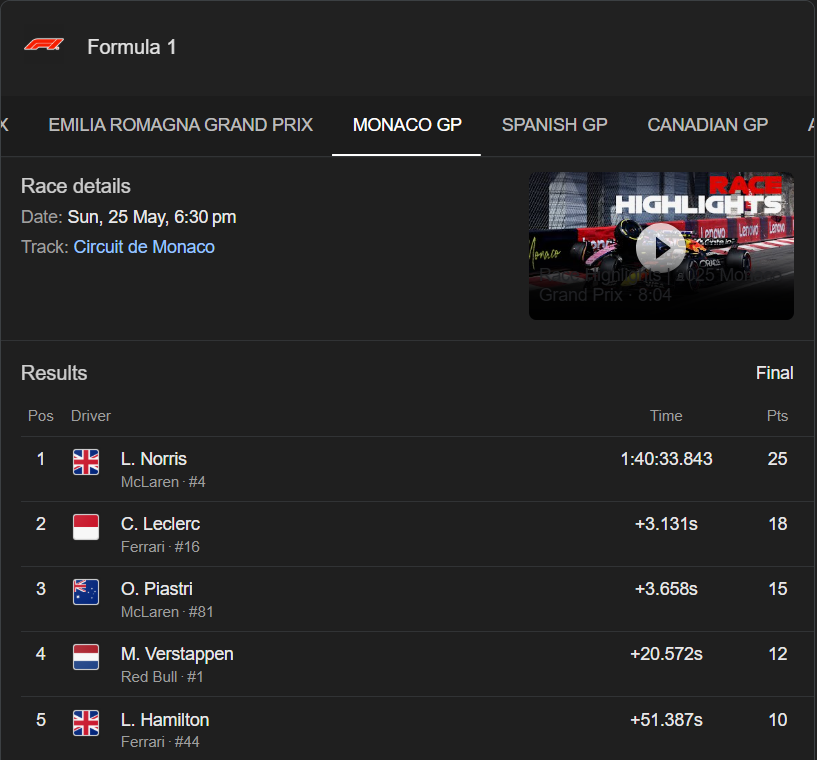